In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix,  ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score



In [3]:
df = pd.read_csv('water_potability.csv')
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [5]:
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

print("\nDescriptive Statistics:\n", df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

Missing Values:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Descriptive Statistics

In [6]:
df['ph'].fillna(df['ph'].median(), inplace=True)
df['Sulfate'] = df.groupby('Potability')['Sulfate'].transform(lambda x: x.fillna(x.median()))
df['Trihalomethanes'].fillna(df['Trihalomethanes'].median(), inplace=True)


/tmp/ipython-input-3733645339.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ph'].fillna(df['ph'].median(), inplace=True)
/tmp/ipython-input-3733645339.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

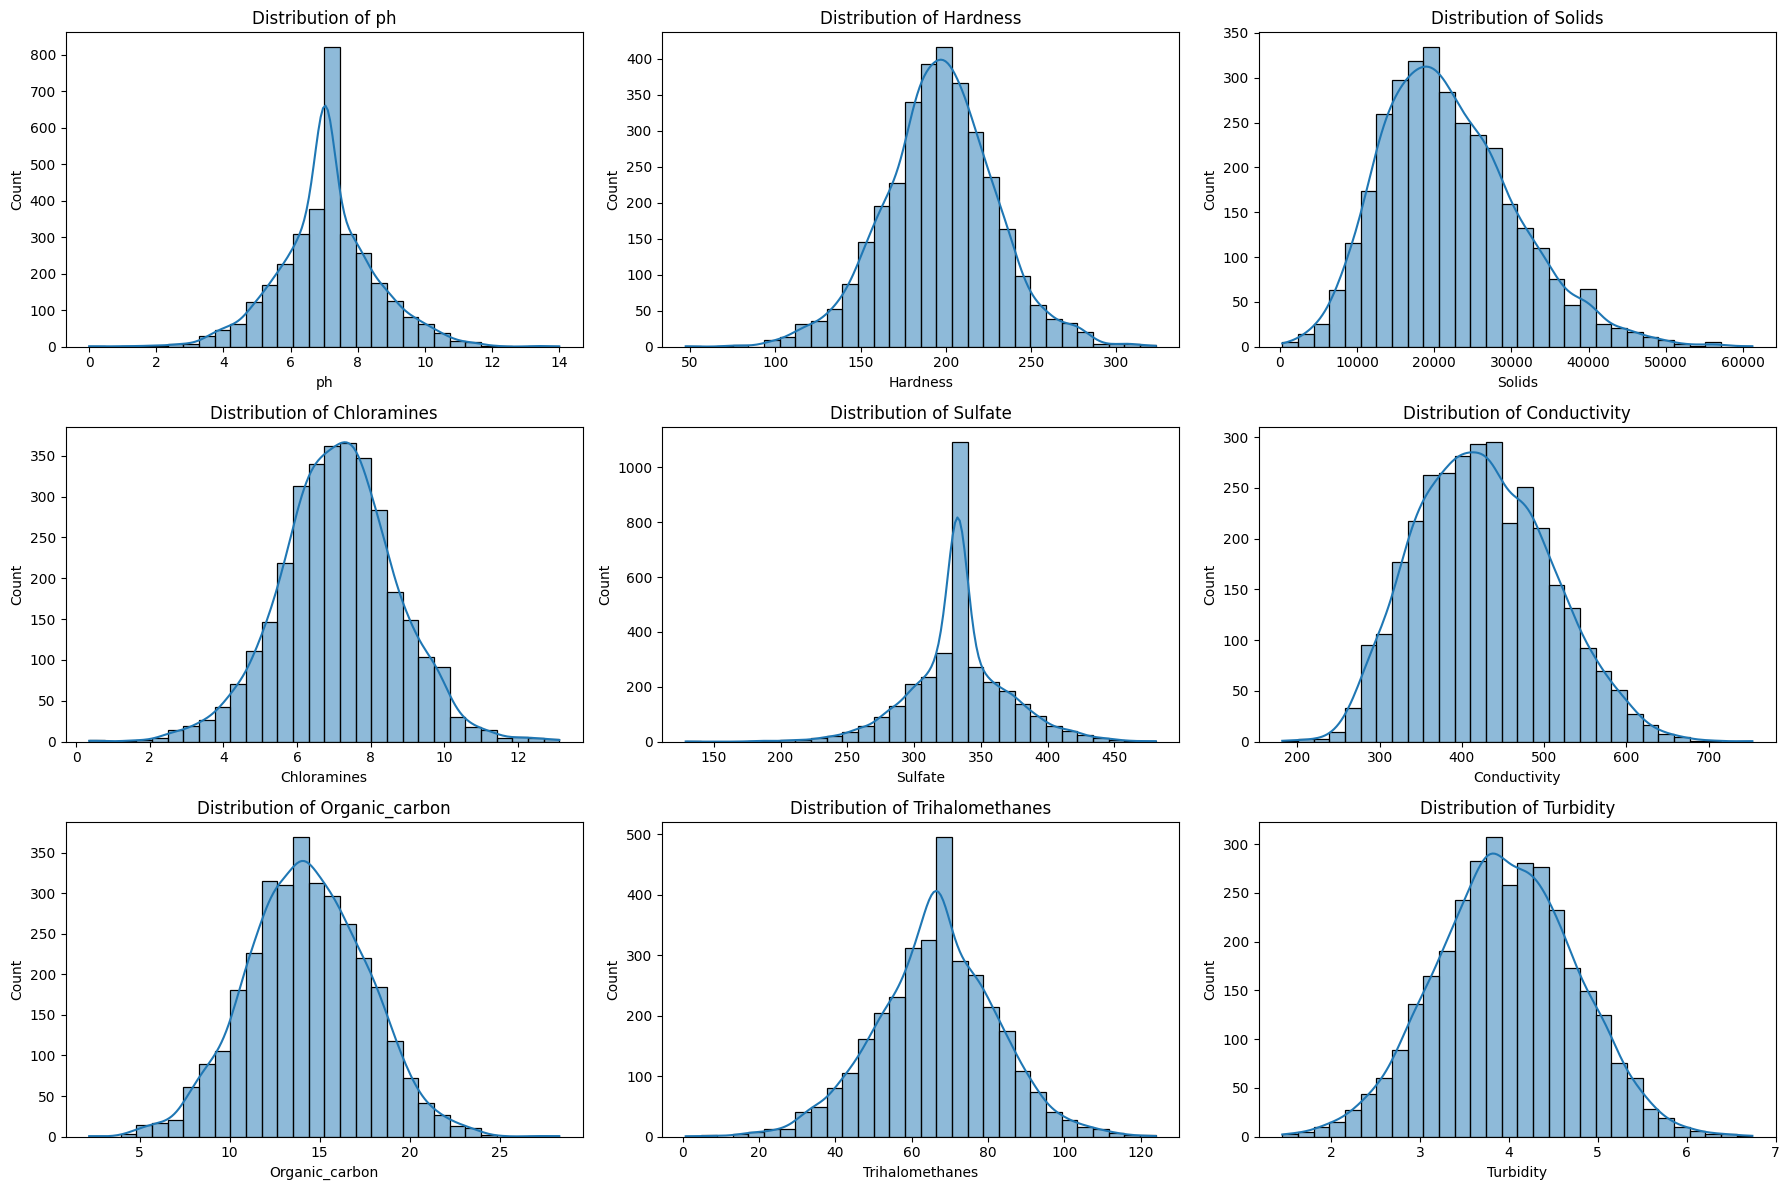

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
           'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

for i, col in enumerate(columns):
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


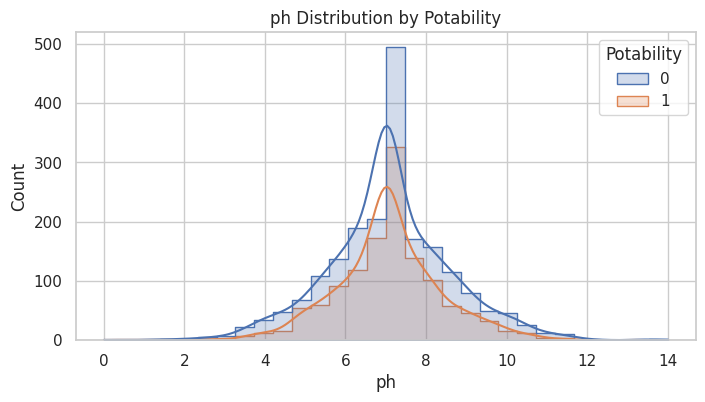

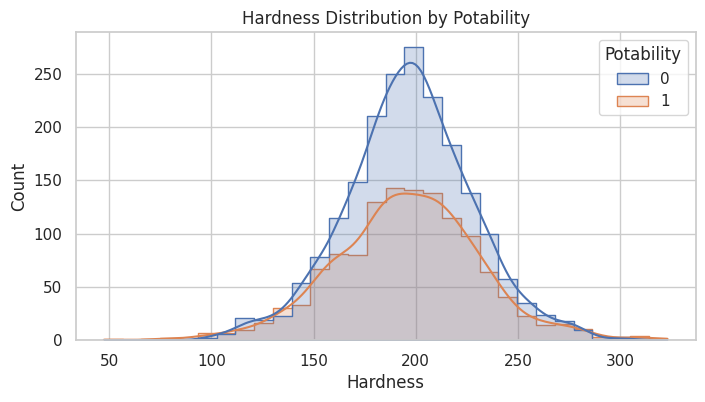

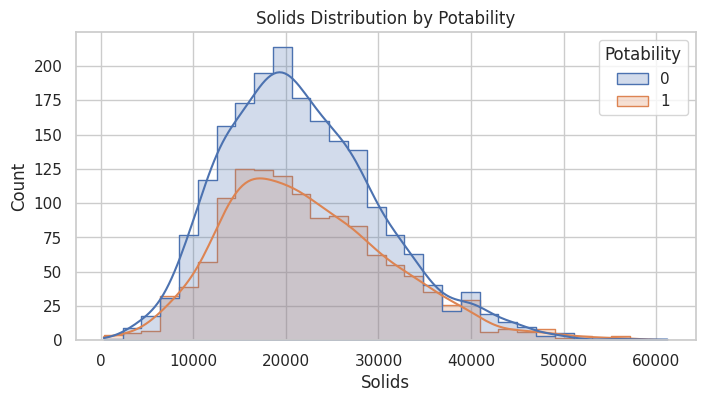

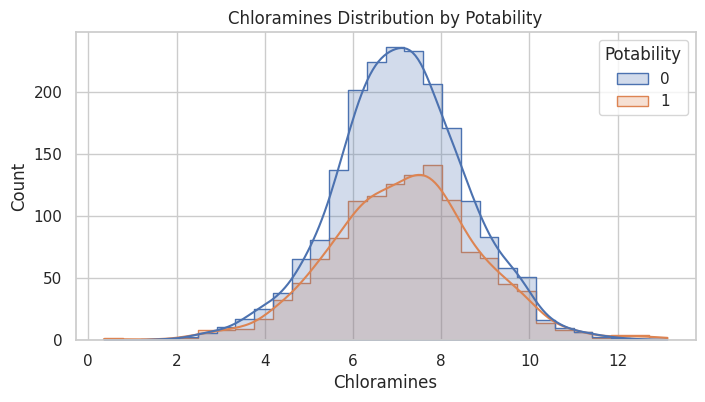

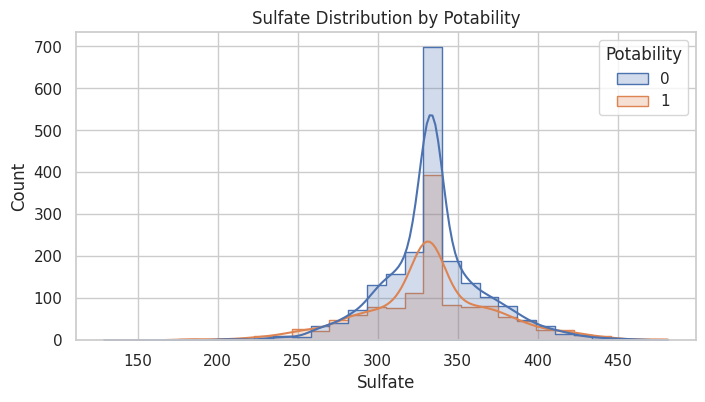

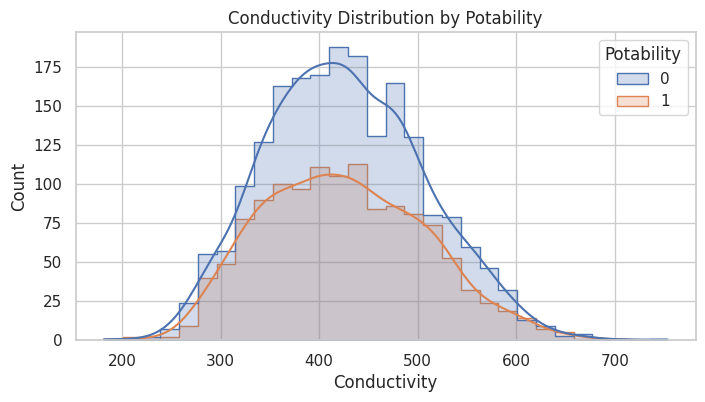

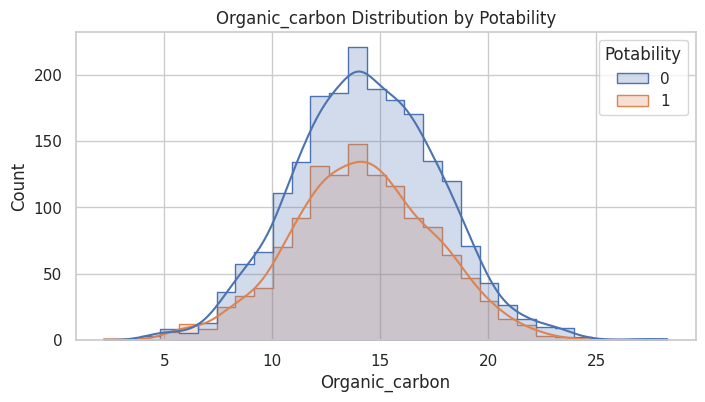

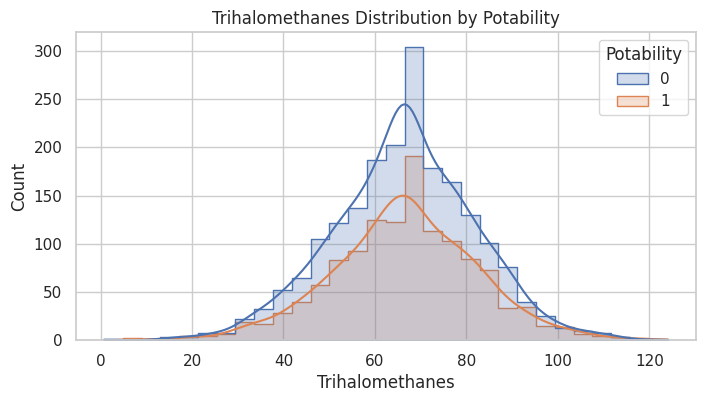

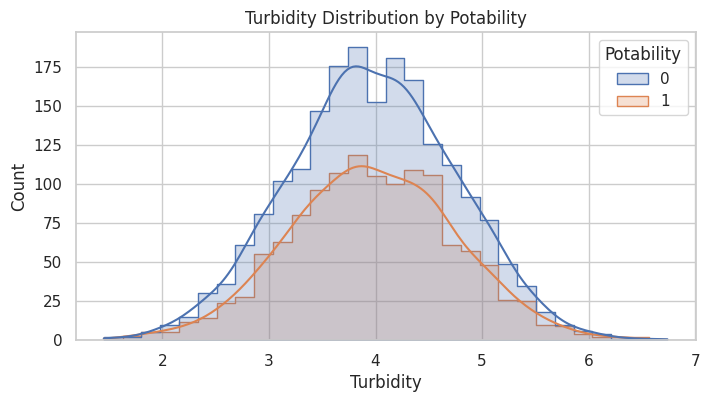

In [8]:
sns.set(style="whitegrid")

# Plot each feature split by Potability
for col in columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Potability', bins=30, kde=True, element="step", common_norm=False)
    plt.title(f"{col} Distribution by Potability")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


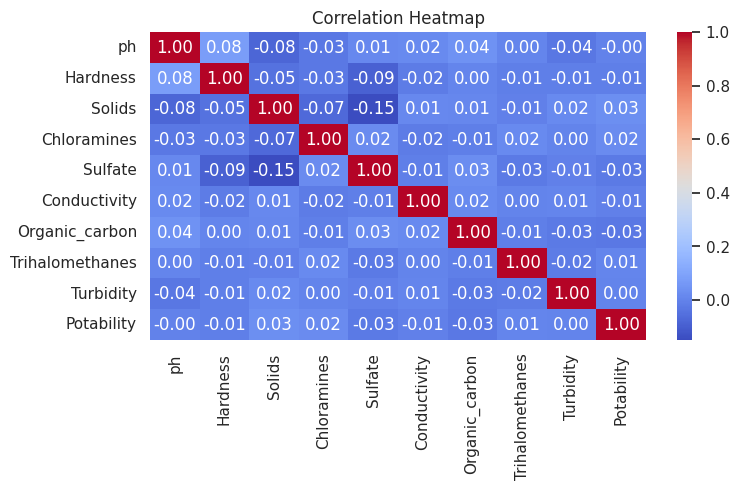

In [9]:
plt.figure(figsize=(8, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


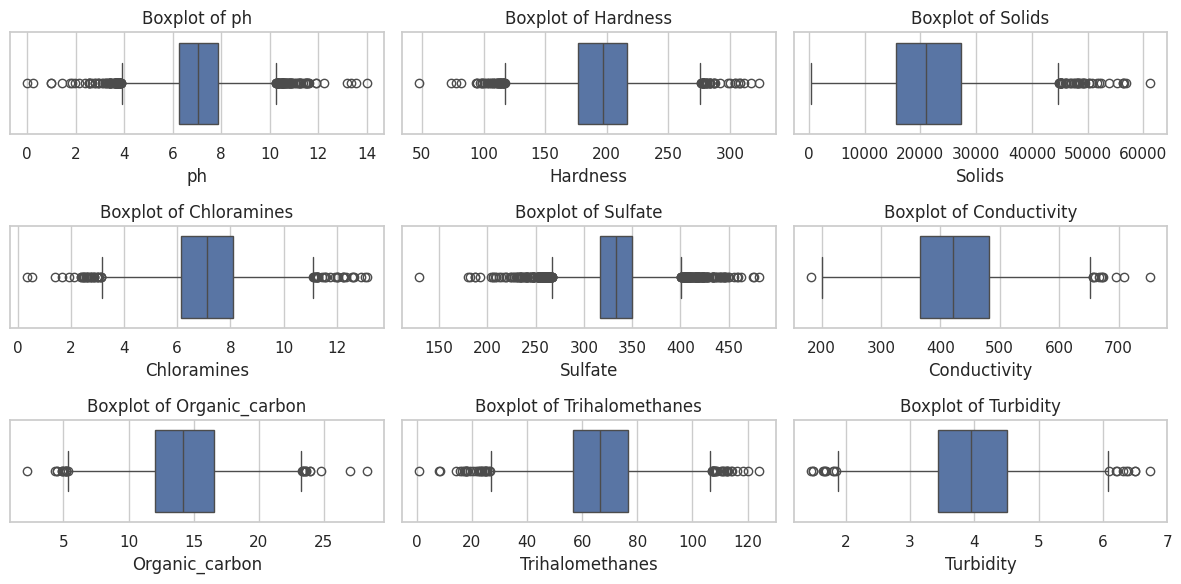

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
            'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

plt.figure(figsize=(12, 6))
for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [11]:
# Detect outliers using IQR
outlier_counts = {}

for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

print("Outliers per column:")
for k, v in outlier_counts.items():
    print(f"{k}: {v}")


Outliers per column:
ph: 142
Hardness: 83
Solids: 47
Chloramines: 61
Sulfate: 264
Conductivity: 11
Organic_carbon: 25
Trihalomethanes: 54
Turbidity: 19


In [12]:
# Capping outliers using IQR bounds
for col in ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
            'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])


In [13]:
df['ph_category'] = pd.cut(df['ph'], bins=[0, 6.5, 7.5, 14], labels=['Acidic', 'Neutral', 'Basic'])

df = pd.get_dummies(df, columns=['ph_category'], drop_first=True)


In [14]:

X = df.drop('Potability', axis=1)
y = df['Potability']



In [15]:
y.value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:
from imblearn.over_sampling import SMOTE

#SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [18]:
# Scale training and test sets independently
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [19]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print()

=== Logistic Regression ===
Accuracy: 0.5030487804878049
Precision: 0.40168539325842695
Recall: 0.55859375
F1 Score: 0.4673202614379085



In [20]:
# === XGBoost ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)
y_pred = xgb.predict(X_test)

# Metrics
print("=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
Accuracy: 0.7225609756097561
Precision: 0.64453125
Recall: 0.64453125
F1 Score: 0.64453125


In [21]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train_res)
y_pred_dt = dt.predict(X_test_scaled)

print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print()

=== Decision Tree ===
Accuracy: 0.7073170731707317
Precision: 0.6212121212121212
Recall: 0.640625
F1 Score: 0.6307692307692307



In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print()

=== Random Forest ===
Accuracy: 0.7454268292682927
Precision: 0.6877637130801688
Recall: 0.63671875
F1 Score: 0.6612576064908722



In [23]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(X_train_scaled, y_train_res)
y_pred_svm = svm.predict(X_test_scaled)

print("=== SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print()

=== SVM ===
Accuracy: 0.6234756097560976
Precision: 0.5207373271889401
Recall: 0.44140625
F1 Score: 0.47780126849894294



In [24]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_res)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score on Training CV:", grid_search.best_score_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

from sklearn.metrics import classification_report
print("\n=== Best Random Forest Evaluation on Test Set ===")
print(classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score on Training CV: 0.758205240814393

=== Best Random Forest Evaluation on Test Set ===
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       400
           1       0.69      0.66      0.67       256

    accuracy                           0.75       656
   macro avg       0.74      0.73      0.74       656
weighted avg       0.75      0.75      0.75       656



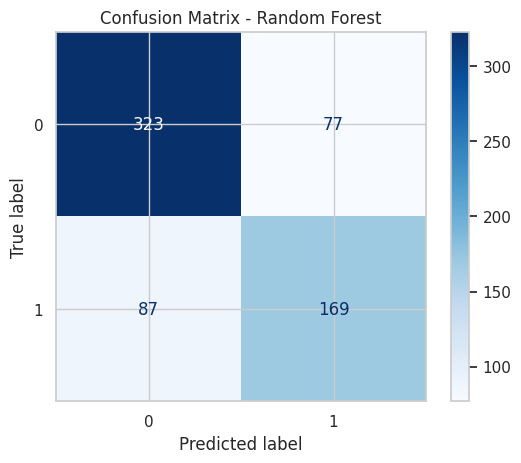

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


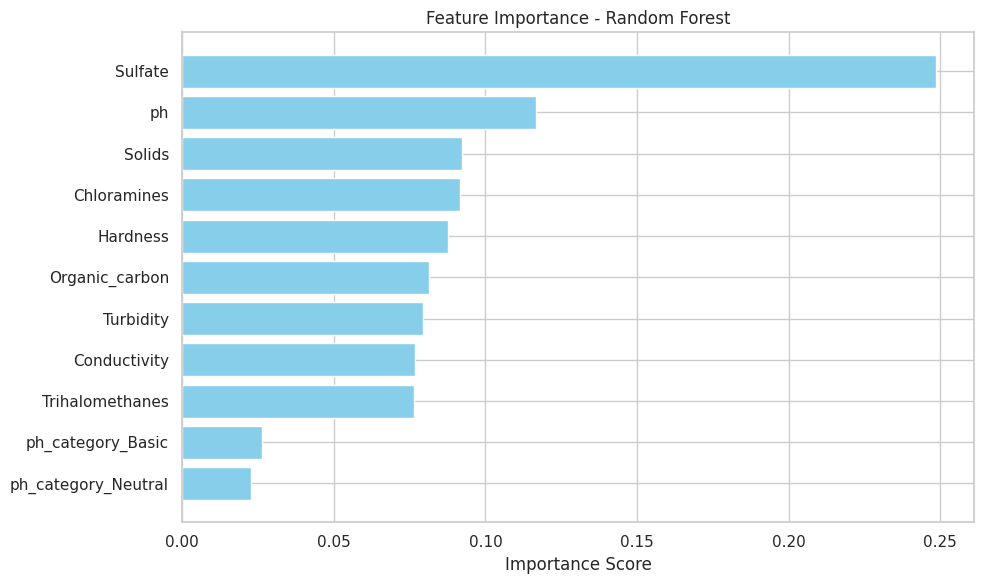

In [26]:
# Feature importances
importances = best_rf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


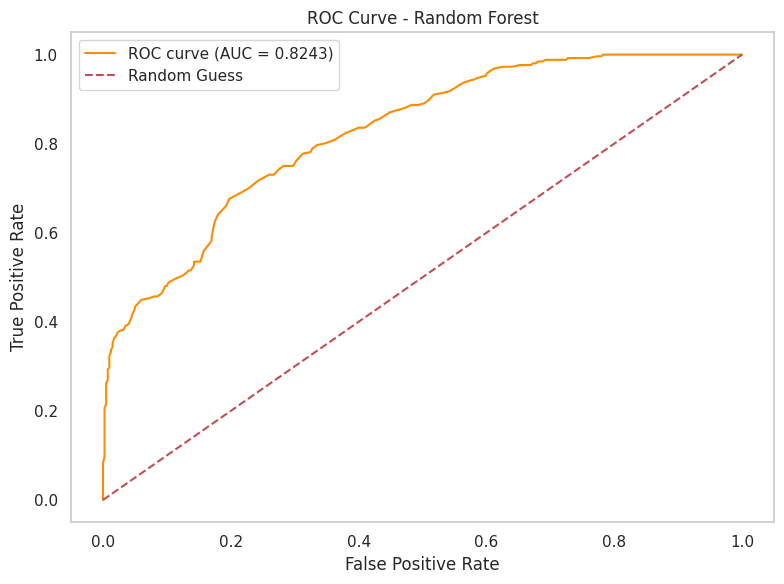

In [27]:
y_probs = best_rf.predict_proba(X_test_scaled)[:, 1]  # Class 1 probability
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

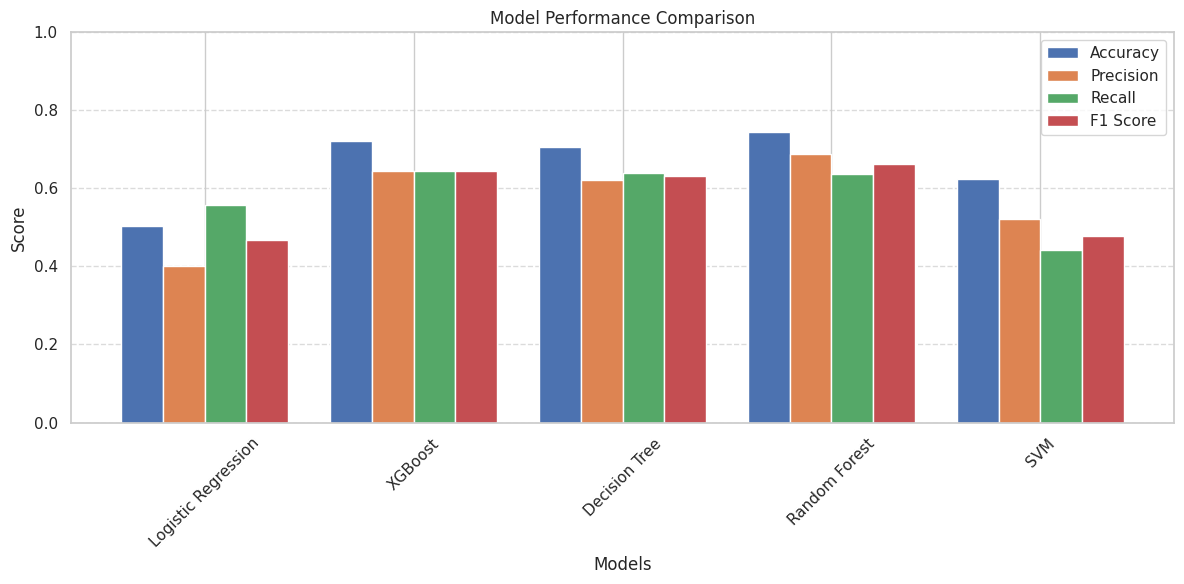

In [28]:
#Evaluation results
results = {
    'Model': ['Logistic Regression', 'XGBoost', 'Decision Tree', 'Random Forest', 'SVM'],
    'Accuracy': [0.5030, 0.7225, 0.7073, 0.7454, 0.6235],
    'Precision': [0.4017, 0.6445, 0.6212, 0.6878, 0.5207],
    'Recall': [0.5586, 0.6445, 0.6406, 0.6367, 0.4414],
    'F1 Score': [0.4673, 0.6445, 0.6308, 0.6613, 0.4778]
}

df_scores = pd.DataFrame(results)

# Plotting
bar_width = 0.2
index = np.arange(len(df_scores['Model']))

plt.figure(figsize=(12, 6))
plt.bar(index, df_scores['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, df_scores['Precision'], bar_width, label='Precision')
plt.bar(index + 2 * bar_width, df_scores['Recall'], bar_width, label='Recall')
plt.bar(index + 3 * bar_width, df_scores['F1 Score'], bar_width, label='F1 Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(index + 1.5 * bar_width, df_scores['Model'], rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


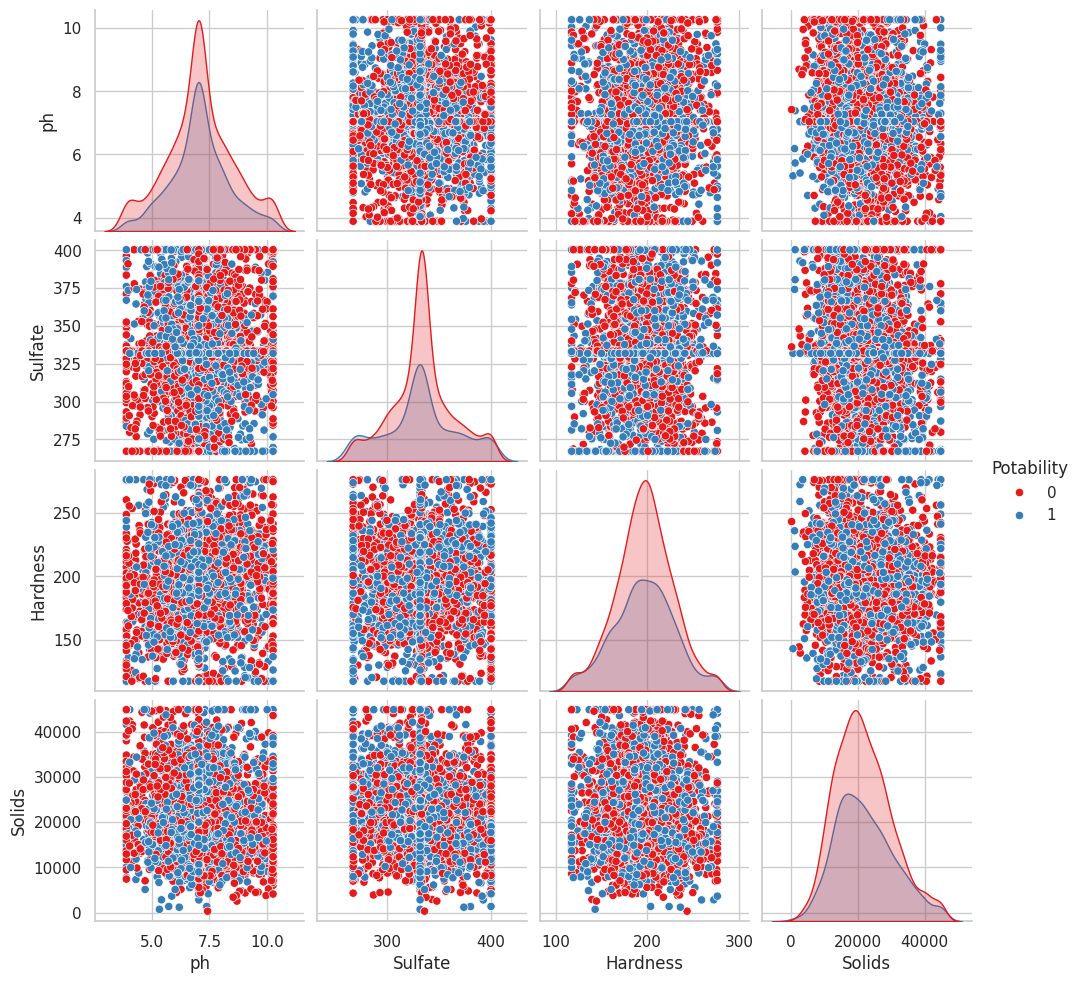

In [29]:
sns.pairplot(df, vars=['ph', 'Sulfate', 'Hardness', 'Solids'], hue='Potability', palette='Set1')



In [30]:
!pip install shap

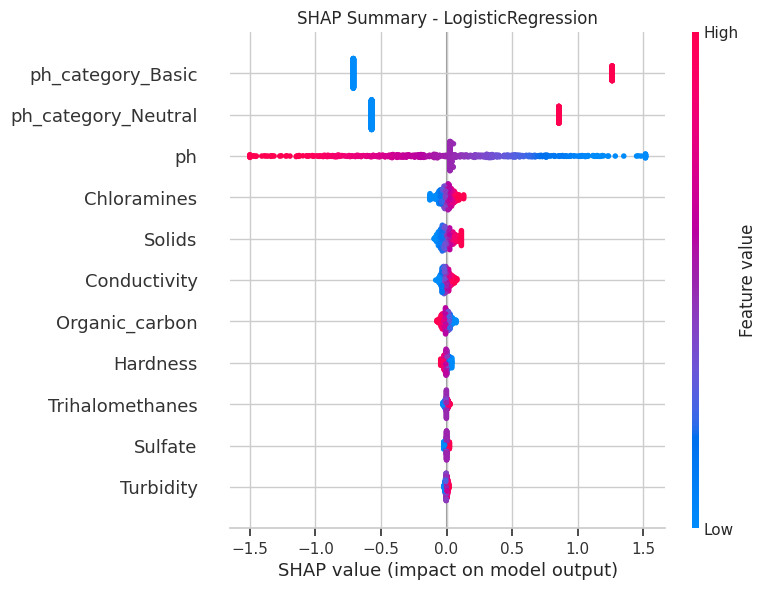

In [31]:
#SHAP
def explain_with_shap(model, X_train_data, X_test_data, model_name="Model"):
    shap.initjs()

    if not isinstance(X_train_data, pd.DataFrame):
        X_train_data = pd.DataFrame(X_train_data, columns=X_train_res.columns)
    if not isinstance(X_test_data, pd.DataFrame):
        X_test_data = pd.DataFrame(X_test_data, columns=X_test.columns)


    model_class = model.__class__.__name__.lower()

    if any(x in model_class for x in ["forest", "xgb", "boost", "tree"]):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_data)
    elif "logistic" in model_class or "linear" in model_class:
        explainer = shap.LinearExplainer(model, X_train_data)
        shap_values = explainer.shap_values(X_test_data)
    else:
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_train_data, 50))
        shap_values = explainer.shap_values(X_test_data.iloc[:50])

    # If shap_values is list, take the positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]

    # Ensure 2D array
    shap_values = np.array(shap_values)

    plt.figure()
    shap.summary_plot(shap_values, X_test_data, feature_names=X_test_data.columns, show=False)
    plt.title(f"SHAP Summary - {model_name}")
    plt.savefig(f"shap_summary_{model_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # force_plot = shap.force_plot(
    #     explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
    #     shap_values[0], X_test_data.iloc[0]
    # )
    # shap.save_html(f"shap_force_{model_name}.html", force_plot)


explain_with_shap(lr, X_train_scaled, X_test_scaled, "LogisticRegression")


  0%|          | 0/50 [00:00<?, ?it/s]

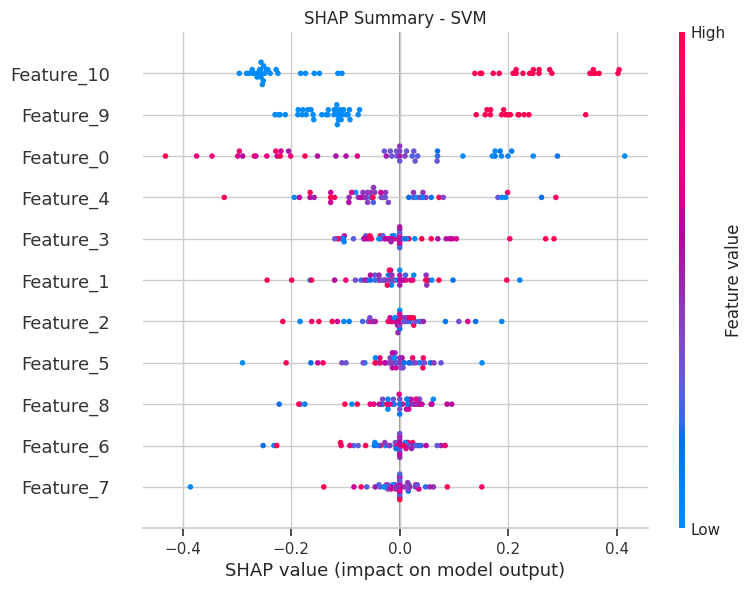

In [32]:
 def explain_with_shap_svm(model, X_train, X_test, model_name="SVM"):
    """
    SHAP explanation specifically for SVM models using KernelExplainer.
    Limits to a subset for speed.
    """
    import shap
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    shap.initjs()

    # Ensure DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=X_test.columns)

    # Limit dataset for speed
    X_train_sample = shap.sample(X_train, 50, random_state=42)
    X_test_sample = X_test.iloc[:50]

    # KernelExplainer for black-box models
    explainer = shap.KernelExplainer(model.predict, X_train_sample)
    shap_values = explainer.shap_values(X_test_sample)

    # For binary classification, select positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    shap_values = np.array(shap_values)

    # Summary plot
    plt.figure()
    shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns, show=False)
    plt.title(f"SHAP Summary - {model_name}")
    plt.savefig(f"shap_summary_{model_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Force plot for first prediction
    force_plot = shap.force_plot(
        explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
        shap_values[0], X_test_sample.iloc[0]
    )
    shap.save_html(f"shap_force_{model_name}.html", force_plot)

 explain_with_shap_svm(svm, X_train_scaled, X_test_scaled, "SVM")

<Figure size 640x480 with 0 Axes>

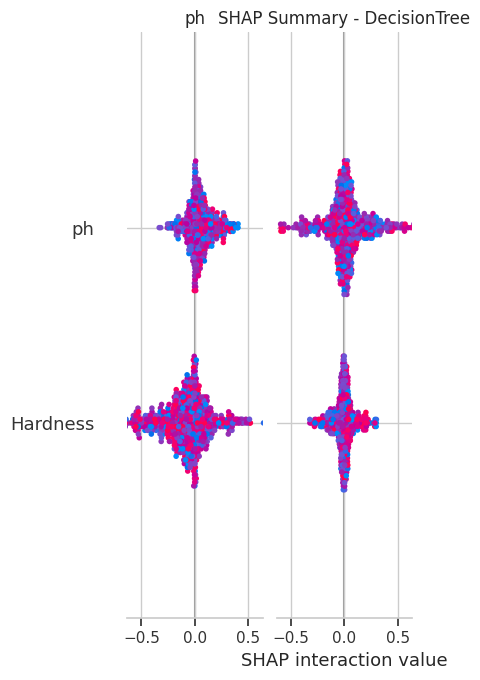

In [33]:
explain_with_shap(dt, X_train_scaled, X_test_scaled, "DecisionTree")

<Figure size 640x480 with 0 Axes>

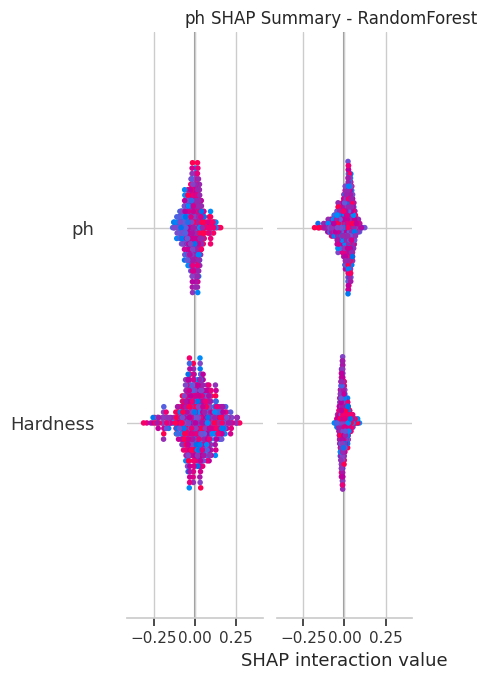

In [34]:
explain_with_shap(best_rf, X_train_scaled, X_test_scaled, "RandomForest")

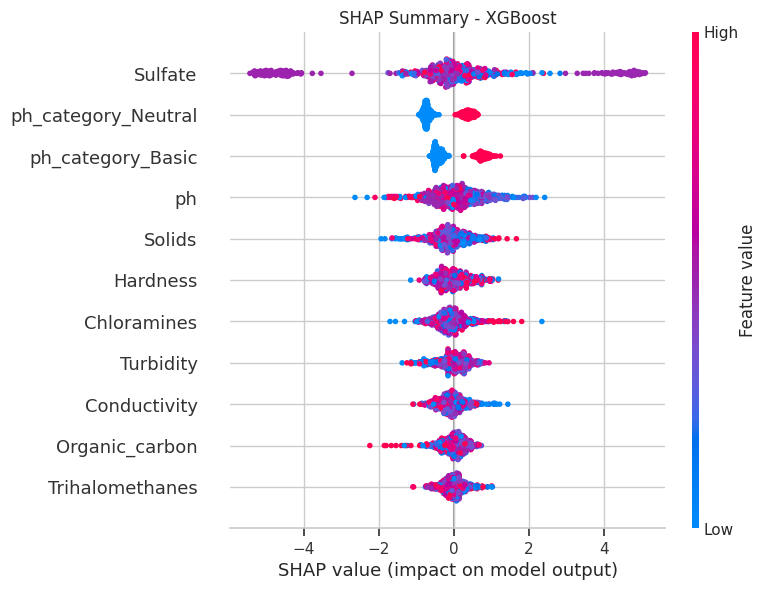

In [35]:
explain_with_shap(xgb, X_train_res, X_test, "XGBoost")

In [36]:
print("This analysis helps identify the key chemical parameters that influence whether water is considered safe for human consumption. These insights can assist in real-world quality control and public health monitoring.")


This analysis helps identify the key chemical parameters that influence whether water is considered safe for human consumption. These insights can assist in real-world quality control and public health monitoring.
